<a href="https://colab.research.google.com/github/bpt2017/MachineLearning/blob/master/PreprocessedMovieReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification with preprocessed text: Movie reviews**

In [1]:
import tensorflow as tf

from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.2.0


In [2]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised=True,
    with_info=True
)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompletePS9709/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompletePS9709/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompletePS9709/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [0]:
encoder = info.features['text'].encoder

In [4]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string ==sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [6]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts,encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


### **Data Explore**

In [10]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [11]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

### **Data Preparation**

In [0]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32)
)

test_batches = (
    test_data
    .padded_batch(32)
)

In [13]:
for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (32, 723)
label shape: (32,)
Batch shape: (32, 1179)
label shape: (32,)


### **Model Building**

In [15]:
model = keras.Sequential([
    keras.layers.Embedding(encoder.vocab_size, 16),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


### **Model Optimization**

In [0]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 8s 10ms/step - loss: 0.6812 - accuracy: 0.5006 - val_loss: 0.6618 - val_accuracy: 0.5052
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 0.6160 - accuracy: 0.5584 - val_loss: 0.5899 - val_accuracy: 0.6062
Epoch 3/10
782/782 [==============================] - 8s 10ms/step - loss: 0.5362 - accuracy: 0.6736 - val_loss: 0.5280 - val_accuracy: 0.6948
Epoch 4/10
782/782 [==============================] - 8s 10ms/step - loss: 0.4690 - accuracy: 0.7588 - val_loss: 0.4780 - val_accuracy: 0.7708
Epoch 5/10
782/782 [==============================] - 8s 10ms/step - loss: 0.4181 - accuracy: 0.8048 - val_loss: 0.4423 - val_accuracy: 0.7844
Epoch 6/10
782/782 [==============================] - 8s 10ms/step - loss: 0.3766 - accuracy: 0.8358 - val_loss: 0.4142 - val_accuracy: 0.8354
Epoch 7/10
782/782 [==============================] - 8s 11ms/step - loss: 0.3465 - accuracy: 0.8554 - val_loss: 0.3953 - val_accuracy: 0.8500

### **Model Evaluation**

In [18]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3346 - accuracy: 0.8387
Loss:  0.33455511927604675
Accuracy:  0.8387200236320496


### Accuracy and loss over time

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

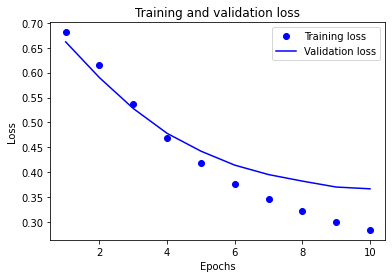

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

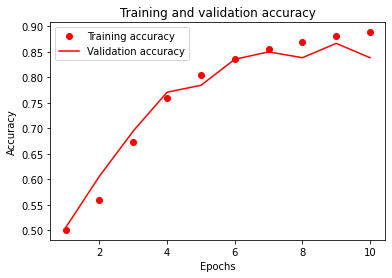

In [21]:
plt.clf()

plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()